In [6]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import torch.nn as nn
import tqdm
import rich

import my_package

In [7]:
class CustomCallback(BaseCallback):
    def __init__(self, total_timesteps: int, print_window: int = 1e4, verbose: int = 0) -> None:
        super(CustomCallback, self).__init__(verbose)
        self.print_window = print_window
        self.losses = []
        self.steps_counter = 0
        self.episodes_counter = 0
        self.rewards_per_ep = []
        self.steps_per_ep = []
        self.max_steps = total_timesteps
        
    def _on_step(self) -> bool:

        # Salvo loss
        if 'train/loss' in self.model.logger.name_to_value:
            self.losses.append(self.model.logger.name_to_value['train/loss'])

        # Salvo info fine episodio
        if self.locals['dones'][0]:
            reward = self.locals['infos'][0]['episode']['r']
            self.rewards_per_ep.append(reward)
            self.episodes_counter += 1
            episode_steps = self.locals['infos'][0]['episode']['l']
            self.steps_per_ep.append(episode_steps)

        if self.steps_counter % self.print_window == 0 and self.steps_counter != 0:
            epsilon = self.model.exploration_rate
            if len(self.rewards_per_ep) > 100:
                ma_reward = np.mean(np.array(self.rewards_per_ep[-100:]))
            else:
                ma_reward = np.mean(np.array(self.rewards_per_ep))
            ma_loss = np.mean(np.array(self.losses[-100:]))
            print(f'Steps: {self.steps_counter}/{self.max_steps}, MA reward: {ma_reward:.2f}, MA loss: {ma_loss:.2f}, eps: {epsilon:.2f}')
        self.steps_counter += 1
        return True

In [8]:
env = Monitor(gym.make('RewardExplorer-v0'))
model = DQN(
    'MlpPolicy',
    env,
    learning_rate =1e-5,
    batch_size = 128,
    buffer_size = 100000,
    learning_starts = 0,
    gamma = 0.99,
    target_update_interval = 250,
    train_freq = 4,
    gradient_steps = -1,
    max_grad_norm=1,
    exploration_fraction = 0.75,
    exploration_final_eps = 0.1,
    policy_kwargs = dict(net_arch=[256, 256]),
    verbose = 0,
)
total_timesteps = 100000

callback = CustomCallback(total_timesteps=total_timesteps, print_window=10000)
model.learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)

total_rewards = np.array(callback.rewards_per_ep)
loss_history = np.array(callback.losses)
len_episodes = np.array(callback.steps_per_ep)

Output()

Steps: 10000/100000, MA reward: -107.53, MA loss: 1.50, eps: 0.88

Steps: 20000/100000, MA reward: -102.80, MA loss: 1.10, eps: 0.76

Steps: 30000/100000, MA reward: -125.75, MA loss: 0.79, eps: 0.64

Steps: 40000/100000, MA reward: -138.18, MA loss: 0.63, eps: 0.52

Steps: 50000/100000, MA reward: -154.43, MA loss: 0.43, eps: 0.40

Steps: 60000/100000, MA reward: -167.09, MA loss: 0.42, eps: 0.28

Steps: 70000/100000, MA reward: -167.49, MA loss: 0.43, eps: 0.16

Steps: 80000/100000, MA reward: -167.13, MA loss: 0.32, eps: 0.10

Steps: 90000/100000, MA reward: -164.75, MA loss: 0.29, eps: 0.10

In [9]:
total_rewards = np.array(callback.rewards_per_ep)
loss_history = np.array(callback.losses)
len_episodes = np.array(callback.steps_per_ep)

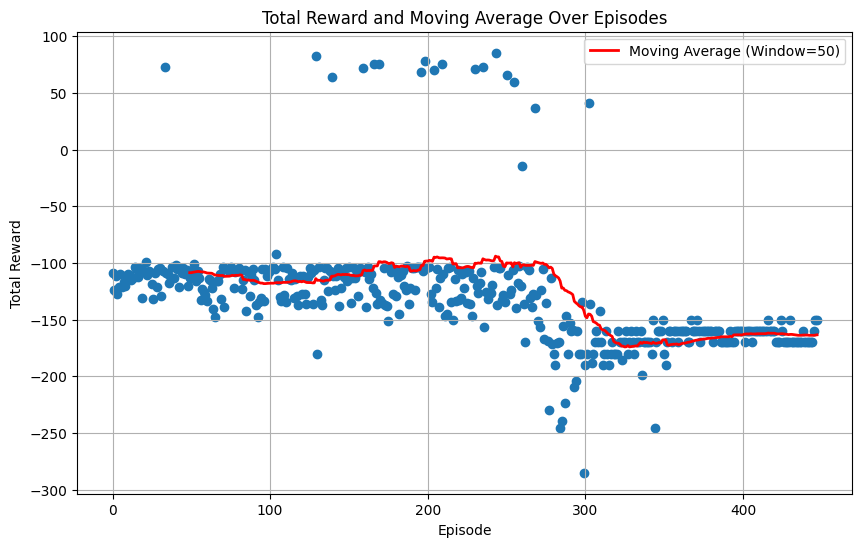

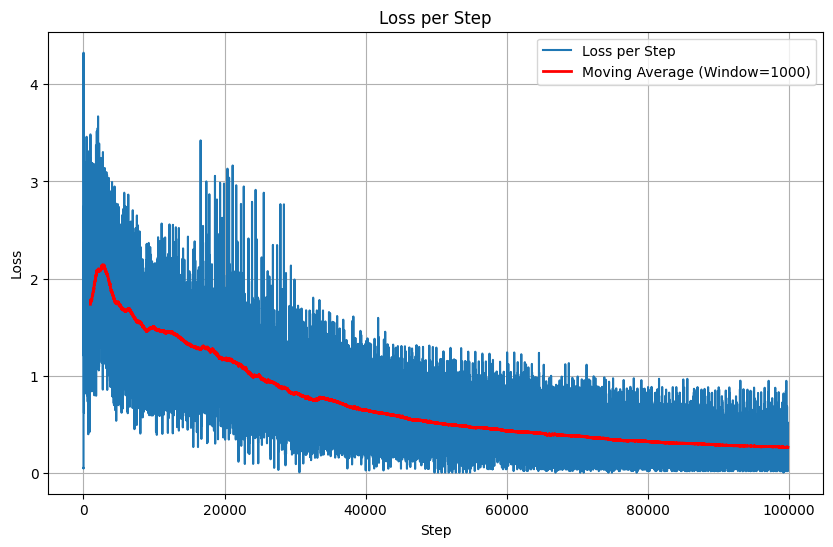

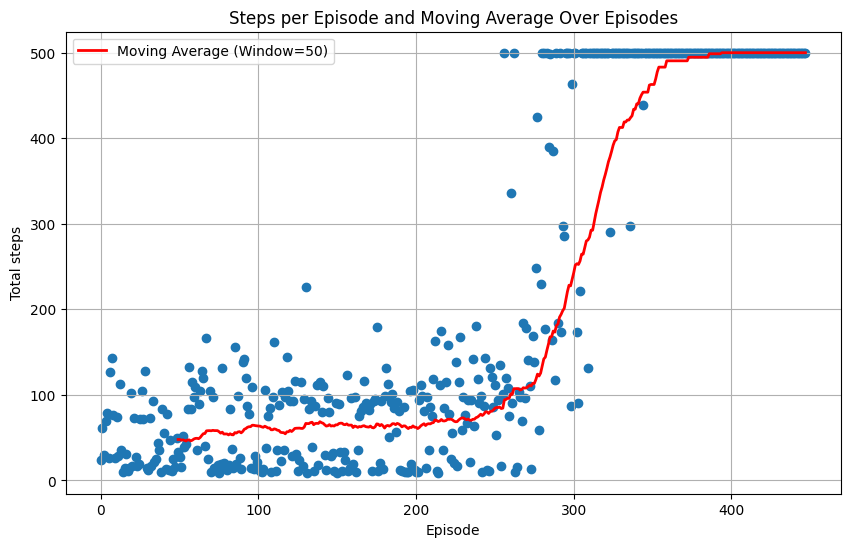

In [10]:
""" Plot rewards """
window_size = 50
ma_reward = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(total_rewards)), total_rewards)
plt.plot(np.arange(window_size - 1, len(total_rewards)), ma_reward, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Total Reward and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

""" Plot loss per step """
window_size = 1000
ma_loss = np.convolve(loss_history, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(loss_history)), loss_history, label='Loss per Step')
plt.plot(np.arange(window_size - 1, len(loss_history)), ma_loss, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Loss per Step')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

""" Plot episode duration """
window_size = 50
ma_steps = np.convolve(len_episodes, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(len_episodes)), len_episodes)
plt.plot(np.arange(window_size - 1, len(len_episodes)), ma_steps, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Steps per Episode and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total steps')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
obs, info = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, truncated, info = env.step(int(action))
    env.render()
env.close()